In [29]:
# ============================================================================
# [1] IMPORT LIBRARIES
# ============================================================================
import pandas as pd
import numpy as np
import warnings
import os
import joblib
warnings.filterwarnings('ignore')

from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from openpyxl import Workbook
from openpyxl.styles import Font, PatternFill, Alignment, Border, Side
from openpyxl.utils import get_column_letter

print("Libraries loaded ✓")

Libraries loaded ✓


In [30]:
# ============================================================================
# [2] LOAD DATA
# ============================================================================
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')

df_history = pd.read_excel('data/Histori Pemakaian Pelanggan_rev0A..xlsx')
df_temuan = pd.read_excel('data/Temuan_rev0A.xlsx')
df_normal = pd.read_excel('data/Normal.xlsx')

print(f"History : {len(df_history):,} rows")
print(f"Temuan  : {len(df_temuan):,} rows (fraud)")
print(f"Normal  : {len(df_normal):,} rows (normal)")

History : 152,974 rows
Temuan  : 177 rows (fraud)
Normal  : 10,647 rows (normal)


In [31]:
# ============================================================================
# [3] CHECK DUPLICATES
# ============================================================================
dup_temuan = df_temuan[df_temuan.duplicated(subset=['IE'], keep=False)]
dup_normal = df_normal[df_normal.duplicated(subset=['IE'], keep=False)]
dup_history = df_history[df_history.duplicated(subset=['IE'], keep=False)]

ie_fraud = set(df_temuan['IE'])
ie_normal = set(df_normal['IE'])
overlap = ie_fraud & ie_normal

print("Duplicates:")
print(f"  Temuan  : {len(dup_temuan)} rows ({df_temuan['IE'].duplicated().sum()} duplicates)")
print(f"  Normal  : {len(dup_normal)} rows ({df_normal['IE'].duplicated().sum()} duplicates)")
print(f"  History : {len(dup_history)} rows ({df_history['IE'].duplicated().sum()} duplicates)")
print(f"\nOverlap Fraud-Normal: {len(overlap)} IE (FRAUD wins)")

Duplicates:
  Temuan  : 2 rows (1 duplicates)
  Normal  : 1345 rows (727 duplicates)
  History : 52 rows (26 duplicates)

Overlap Fraud-Normal: 10 IE (FRAUD wins)


In [32]:
# ============================================================================
# [4] CLEAN DUPLICATES
# ============================================================================
# Remove duplicates
df_temuan_clean = df_temuan.drop_duplicates(subset=['IE'], keep='last')
df_normal_clean = df_normal.drop_duplicates(subset=['IE'], keep='first')
df_history_clean = df_history.drop_duplicates(subset=['IE'], keep='first')

# Remove overlap from Normal (FRAUD wins)
ie_fraud = set(df_temuan_clean['IE'])
df_normal_clean = df_normal_clean[~df_normal_clean['IE'].isin(ie_fraud)]

print("After cleaning:")
print(f"  Temuan  : {len(df_temuan):,} → {len(df_temuan_clean):,}")
print(f"  Normal  : {len(df_normal):,} → {len(df_normal_clean):,}")
print(f"  History : {len(df_history):,} → {len(df_history_clean):,}")

After cleaning:
  Temuan  : 177 → 176
  Normal  : 10,647 → 9,910
  History : 152,974 → 152,948


In [33]:
# ============================================================================
# [5] LABELING
# ============================================================================
# Label: 1 = Fraud (Temuan), 0 = Normal, -1 = Unknown
ie_fraud = set(df_temuan_clean['IE'])
ie_normal = set(df_normal_clean['IE'])

def assign_label(ie):
    if ie in ie_fraud:
        return 1
    elif ie in ie_normal:
        return 0
    return -1

df_history_clean['label'] = df_history_clean['IE'].apply(assign_label)

label_counts = df_history_clean['label'].value_counts()
print("Labels assigned:")
print(f"  Fraud (1)   : {label_counts.get(1, 0):,}")
print(f"  Normal (0)  : {label_counts.get(0, 0):,}")
print(f"  Unknown (-1): {label_counts.get(-1, 0):,}")

Labels assigned:
  Fraud (1)   : 176
  Normal (0)  : 9,889
  Unknown (-1): 142,883


In [34]:
# ============================================================================
# [6] DATA INSPECTION
# ============================================================================
print("Column names:")
print(f"  {list(df_history_clean.columns[:5])} ... ({len(df_history_clean.columns)} total)")

print(f"\nData shape: {df_history_clean.shape}")
print(f"\nData types:")
print(df_history_clean.dtypes.value_counts())

print(f"\nMissing values:")
missing = df_history_clean.isnull().sum()
missing_cols = missing[missing > 0]
if len(missing_cols) > 0:
    print(missing_cols)
else:
    print("  No missing values ✓")

Column names:
  ['UE', 'IE', 'TARIF', 'DAYA', datetime.datetime(2021, 3, 1, 0, 0)] ... (64 total)

Data shape: (152948, 64)

Data types:
float64    60
object      3
int64       1
Name: count, dtype: int64

Missing values:
TARIF                  13412
DAYA                   13412
2021-03-01 00:00:00     8944
2021-04-01 00:00:00     8881
2021-05-01 00:00:00     8826
                       ...  
2025-09-01 00:00:00    16270
2025-10-01 00:00:00    15778
2025-11-01 00:00:00    15093
2025-12-01 00:00:00    14724
2026-01-01 00:00:00    14307
Length: 61, dtype: int64


In [35]:
# ============================================================================
# [7] EXTRACT DATE COLUMNS
# ============================================================================
non_date_cols = ['IE', 'UE', 'TARIF', 'DAYA', 'label']
date_columns = [col for col in df_history_clean.columns if col not in non_date_cols]
date_columns = sorted(date_columns)

print(f"Date columns: {len(date_columns)}")
print(f"  First: {date_columns[0]}")
print(f"  Last : {date_columns[-1]}")
print(f"  Range: {len(date_columns)} months")

Date columns: 59
  First: 2021-03-01 00:00:00
  Last : 2026-01-01 00:00:00
  Range: 59 months


In [58]:
# ============================================================================
# [8] HANDLE MISSING VALUES
# ============================================================================
# Fill NaN in usage columns with 0
df_history_clean[date_columns] = df_history_clean[date_columns].fillna(0)

# Check result
remaining_na = df_history_clean.isnull().sum().sum()
print(f"Missing values filled: {remaining_na} remaining")

Missing values filled: 26824 remaining


In [59]:
# ============================================================================
# [9] FILTER INACTIVE CUSTOMERS (N/A at end = Unsubscribed)
# ============================================================================
# Check last 3 months - if all NaN/0, likely unsubscribed
last_3_cols = date_columns[-3:]

def is_unsubscribed(row):
    """Customer with NaN at the end = no longer subscribed"""
    last_3_vals = row[last_3_cols].values
    # Check if ALL last 3 months are NaN (before fillna)
    return pd.isna(last_3_vals).all()

# Need to check BEFORE fillna - reload and check
df_temp = df_history.drop_duplicates(subset=['IE'], keep='first')

# Check unsubscribed pattern
unsubscribed_mask = df_temp[last_3_cols].isna().all(axis=1)
unsubscribed_count = unsubscribed_mask.sum()

print(f"Customers with N/A in last 3 months (unsubscribed): {unsubscribed_count:,}")

# Filter out unsubscribed from df_history_clean
unsubscribed_ie = set(df_temp[unsubscribed_mask]['IE'])
before = len(df_history_clean)
df_history_clean = df_history_clean[~df_history_clean['IE'].isin(unsubscribed_ie)]
after = len(df_history_clean)

print(f"Removed: {before - after:,} unsubscribed customers")
print(f"Remaining: {after:,} active customers")

Customers with N/A in last 3 months (unsubscribed): 13,904
Removed: 13,904 unsubscribed customers
Remaining: 139,044 active customers


In [60]:
# ============================================================================
# [9] BASIC STATISTICS
# ============================================================================
usage_matrix = df_history_clean[date_columns].values

print("Usage Statistics:")
print(f"  Min  : {usage_matrix.min():.2f}")
print(f"  Max  : {usage_matrix.max():.2f}")
print(f"  Mean : {usage_matrix.mean():.2f}")
print(f"  Std  : {usage_matrix.std():.2f}")

# Statistics by label
for label in [1, 0, -1]:
    label_name = {1: 'Fraud', 0: 'Normal', -1: 'Unknown'}[label]
    mask = df_history_clean['label'] == label
    if mask.sum() > 0:
        values = df_history_clean.loc[mask, date_columns].values
        print(f"\n{label_name}:")
        print(f"  Mean: {values.mean():.2f}")
        print(f"  Std : {values.std():.2f}")

Usage Statistics:
  Min  : 0.00
  Max  : 24229392.00
  Mean : 595.21
  Std  : 20718.42

Fraud:
  Mean: 218.87
  Std : 244.10

Normal:
  Mean: 304.08
  Std : 776.66

Unknown:
  Mean: 617.83
  Std : 21503.14


In [61]:
# ============================================================================
# [10] VISUALIZATION - Import Matplotlib
# ============================================================================
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("Matplotlib ready ✓")

Matplotlib ready ✓


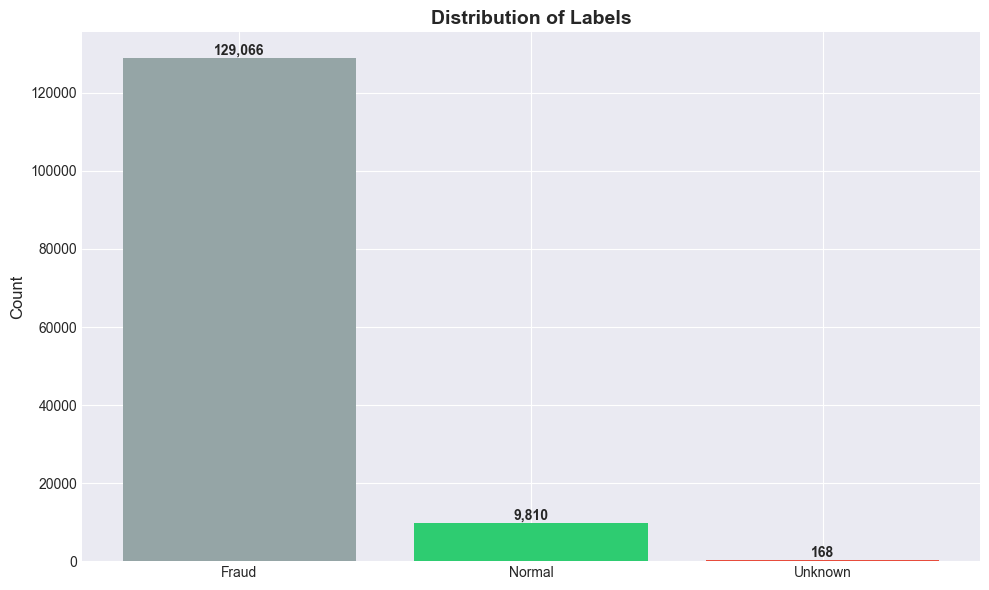

In [62]:
# ============================================================================
# [11] VISUALIZATION - Label Distribution
# ============================================================================
fig, ax = plt.subplots(figsize=(10, 6))

label_counts = df_history_clean['label'].value_counts().sort_index()
labels = ['Normal', 'Fraud', 'Unknown']
colors_map = {0: '#2ecc71', 1: '#e74c3c', -1: '#95a5a6'}

bars = ax.bar(range(len(label_counts)), label_counts.values, 
              color=[colors_map[k] for k in label_counts.index])

ax.set_xticks(range(len(label_counts)))
ax.set_xticklabels([labels[1], labels[0], labels[2]])
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Distribution of Labels', fontsize=14, fontweight='bold')

# Add value labels
for i, (k, v) in enumerate(label_counts.items()):
    ax.text(i, v, f'{v:,}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

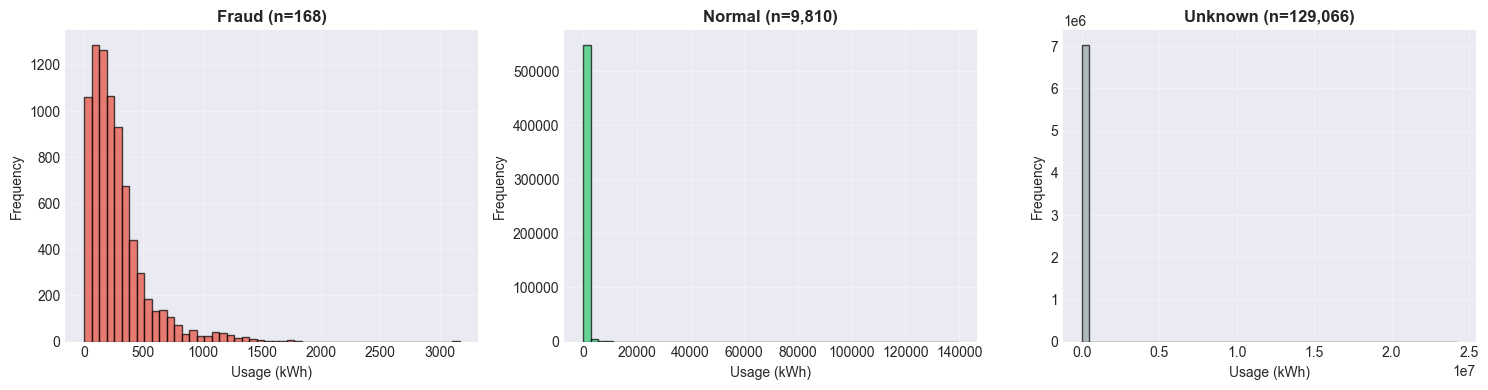

In [63]:
# ============================================================================
# [12] VISUALIZATION - Usage Distribution by Label
# ============================================================================
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

labels_map = {1: 'Fraud', 0: 'Normal', -1: 'Unknown'}
colors_map = {1: '#e74c3c', 0: '#2ecc71', -1: '#95a5a6'}

for idx, label in enumerate([1, 0, -1]):
    mask = df_history_clean['label'] == label
    data = df_history_clean.loc[mask, date_columns].values.flatten()
    data = data[data > 0]  # Only non-zero values
    
    axes[idx].hist(data, bins=50, color=colors_map[label], alpha=0.7, edgecolor='black')
    axes[idx].set_title(f'{labels_map[label]} (n={mask.sum():,})', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Usage (kWh)', fontsize=10)
    axes[idx].set_ylabel('Frequency', fontsize=10)
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

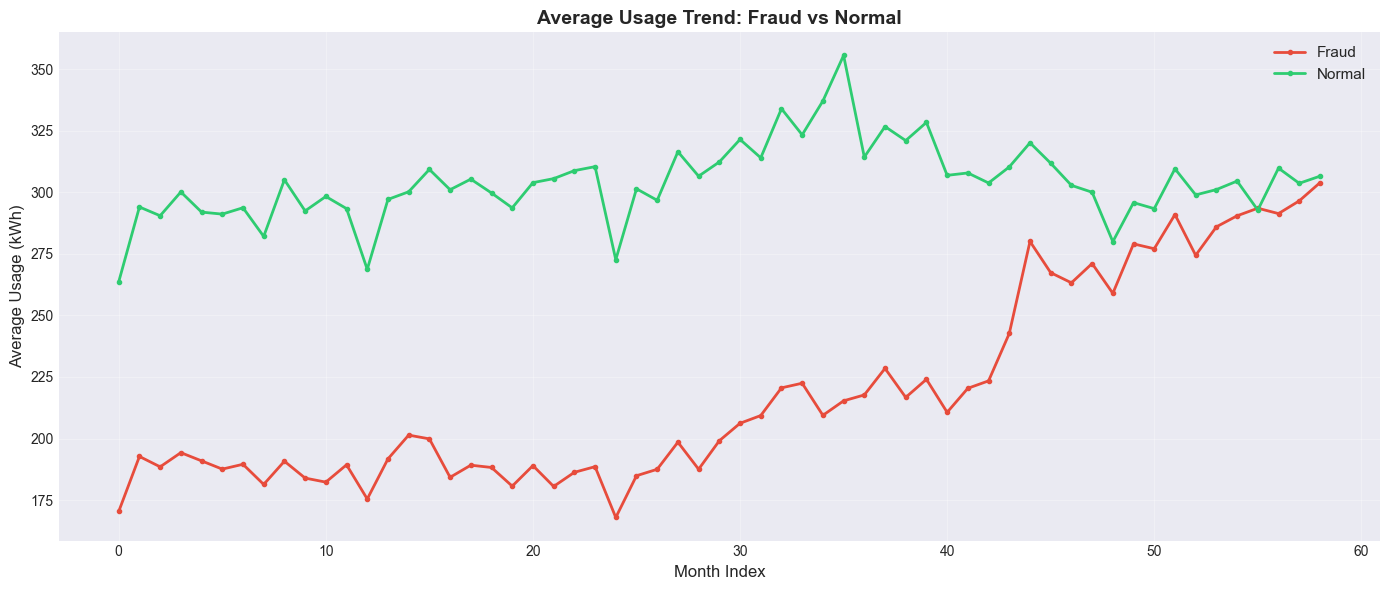

In [64]:
# ============================================================================
# [13] VISUALIZATION - Average Usage Trend Over Time
# ============================================================================
fig, ax = plt.subplots(figsize=(14, 6))

for label in [1, 0]:
    mask = df_history_clean['label'] == label
    avg_usage = df_history_clean.loc[mask, date_columns].mean()
    
    label_name = 'Fraud' if label == 1 else 'Normal'
    color = '#e74c3c' if label == 1 else '#2ecc71'
    
    ax.plot(range(len(date_columns)), avg_usage.values, 
            label=label_name, color=color, linewidth=2, marker='o', markersize=3)

ax.set_xlabel('Month Index', fontsize=12)
ax.set_ylabel('Average Usage (kWh)', fontsize=12)
ax.set_title('Average Usage Trend: Fraud vs Normal', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

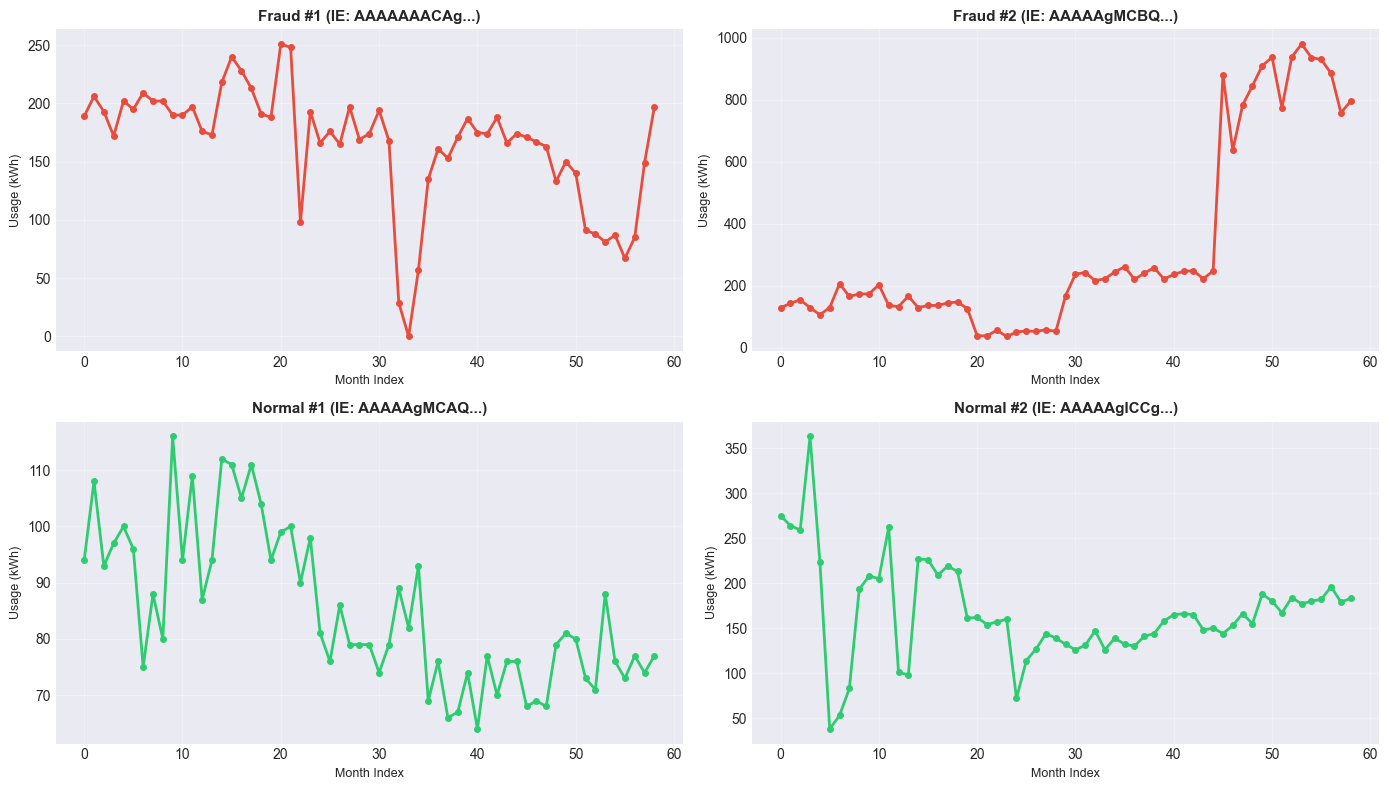

In [65]:
# ============================================================================
# [14] VISUALIZATION - Sample Customer Patterns
# ============================================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Sample 2 fraud and 2 normal customers
fraud_samples = df_history_clean[df_history_clean['label'] == 1].sample(2, random_state=42)
normal_samples = df_history_clean[df_history_clean['label'] == 0].sample(2, random_state=42)

samples = [(fraud_samples.iloc[0], 'Fraud #1', '#e74c3c'),
           (fraud_samples.iloc[1], 'Fraud #2', '#e74c3c'),
           (normal_samples.iloc[0], 'Normal #1', '#2ecc71'),
           (normal_samples.iloc[1], 'Normal #2', '#2ecc71')]

for idx, (row, title, color) in enumerate(samples):
    ax = axes[idx // 2, idx % 2]
    usage = row[date_columns].values
    
    ax.plot(range(len(usage)), usage, color=color, linewidth=2, marker='o', markersize=4)
    ax.set_title(f'{title} (IE: {row["IE"][:10]}...)', fontsize=11, fontweight='bold')
    ax.set_xlabel('Month Index', fontsize=9)
    ax.set_ylabel('Usage (kWh)', fontsize=9)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# ============================================================================
# [15] ADVANCED FEATURE EXTRACTOR CLASS (21 Features)
# ============================================================================
from scipy import stats

class ElectricityTheftFeatureExtractor:
    """
    Extract 21 optimized features for electricity theft detection
    Based on 3 fraud patterns: Zero fraud, Gradual decline, Sudden spike
    """
    
    def __init__(self, df_normal, date_columns, tarif_col='TARIF', ue_col='UE', daya_col='DAYA'):
        self.df_normal = df_normal
        self.date_columns = date_columns
        self.tarif_col = tarif_col
        self.ue_col = ue_col
        self.daya_col = daya_col
        
        # Build benchmarks from NORMAL data
        self._build_benchmarks()
        
    def _build_benchmarks(self):
        """Build statistical benchmarks from normal customers"""
        print("Building benchmarks from NORMAL customers...")
        
        # Group by TARIF
        self.tarif_stats = {}
        for tarif in self.df_normal[self.tarif_col].unique():
            mask = self.df_normal[self.tarif_col] == tarif
            usage = self.df_normal.loc[mask, self.date_columns].values.flatten()
            usage = usage[usage > 0]  # Only non-zero
            
            if len(usage) > 0:
                self.tarif_stats[tarif] = {
                    'mean': usage.mean(),
                    'std': usage.std() + 1e-6,
                    'median': np.median(usage)
                }
        
        # Group by UE (neighborhood)
        self.ue_stats = {}
        for ue in self.df_normal[self.ue_col].unique():
            mask = self.df_normal[self.ue_col] == ue
            usage = self.df_normal.loc[mask, self.date_columns].values.flatten()
            usage = usage[usage > 0]
            
            if len(usage) > 0:
                self.ue_stats[ue] = usage
        
        print(f"  Tarif groups: {len(self.tarif_stats)}")
        print(f"  UE groups: {len(self.ue_stats)}")
    
    def extract_features(self, df):
        """Extract all 21 features from dataframe"""
        print(f"Extracting 21 features from {len(df):,} customers...")
        
        # Reset index untuk mudahkan mapping
        df_work = df.reset_index(drop=True)
        features = pd.DataFrame(index=df_work.index)
        usage_matrix = df_work[self.date_columns].values
        
        # === TIER S: Universal (5 features) ===
        print("  [TIER S] Universal features...")
        features['tariff_zscore'] = self._tariff_zscore_vectorized(df_work, usage_matrix)
        features['usage_vs_expected'] = self._usage_vs_expected_vectorized(df_work, usage_matrix)
        features['neighborhood_percentile'] = self._neighborhood_percentile_vectorized(df_work, usage_matrix)
        features['cv'] = self._coefficient_variation(usage_matrix)
        features['zero_fraud_score'] = self._zero_fraud_score(usage_matrix)
        
        # === TIER A: Pattern Detection (10 features) ===
        print("  [TIER A] Pattern detection...")
        features['plateau_months'] = self._plateau_months(usage_matrix)
        features['gradual_decline'] = self._gradual_decline(usage_matrix)
        features['max_consecutive_zero'] = self._max_consecutive_zero(usage_matrix)
        features['zero_clusters'] = self._zero_clusters(usage_matrix)
        features['extreme_spike_count'] = self._extreme_spike_count(usage_matrix)
        features['sudden_drop_count'] = self._sudden_drop_count(usage_matrix)
        features['consecutive_below_threshold'] = self._consecutive_below_threshold(usage_matrix)
        features['drop_recovery_pattern'] = self._drop_recovery_pattern(usage_matrix)
        features['variance_spike_count'] = self._variance_spike_count(usage_matrix)
        features['max_drop_from_baseline'] = self._max_drop_from_baseline(usage_matrix)
        
        # === TIER B: Tapping & ROI (3 features) ===
        print("  [TIER B] Tapping & ROI...")
        features['sudden_spike_sustained'] = self._sudden_spike_sustained(usage_matrix)
        features['estimated_monthly_loss'] = self._estimated_monthly_loss_vectorized(df_work, usage_matrix)
        features['investigation_roi'] = self._investigation_roi(features, df_work)
        
        # === TIER C: Enhanced Zero (3 features) ===
        print("  [TIER C] Enhanced zero detection...")
        features['zero_pattern_legitimacy'] = self._zero_pattern_legitimacy(usage_matrix)
        features['zero_to_nonzero_transition'] = self._zero_to_nonzero_transition(usage_matrix)
        features['post_zero_spike_severity'] = self._post_zero_spike_severity(usage_matrix)
        
        # Restore original index
        features.index = df.index
        
        print(f"✓ Extracted {features.shape[1]} features")
        return features
    
    # =========================================================================
    # TIER S: Universal Features (Vectorized)
    # ========================================h=================================
    
    def _tariff_zscore_vectorized(self, df, usage_matrix):
        """Z-score vs normal customers with same tariff"""
        result = np.zeros(len(df))
        mean_usage = np.array([row[row > 0].mean() if (row > 0).any() else 0 for row in usage_matrix])
        
        for tarif, stats in self.tarif_stats.items():
            mask = df[self.tarif_col] == tarif
            if mask.any():
                zscore = (mean_usage[mask] - stats['mean']) / stats['std']
                result[mask] = zscore
        
        return result
    
    def _usage_vs_expected_vectorized(self, df, usage_matrix):
        """Ratio actual/expected usage"""
        result = np.ones(len(df))
        mean_usage = np.array([row[row > 0].mean() if (row > 0).any() else 0 for row in usage_matrix])
        
        for tarif, stats in self.tarif_stats.items():
            mask = df[self.tarif_col] == tarif
            if mask.any():
                ratio = mean_usage[mask] / (stats['median'] + 1e-6)
                result[mask] = ratio
        
        return result
    
    def _neighborhood_percentile_vectorized(self, df, usage_matrix):
        """Percentile in same neighborhood (UE)"""
        result = np.full(len(df), 50.0)
        mean_usage = np.array([row[row > 0].mean() if (row > 0).any() else 0 for row in usage_matrix])
        
        for ue, ue_usage in self.ue_stats.items():
            mask = df[self.ue_col] == ue
            if mask.any():
                percentiles = [stats.percentileofscore(ue_usage, val) for val in mean_usage[mask]]
                result[mask] = percentiles
        
        return result
    
    def _coefficient_variation(self, usage_matrix):
        """CV = std / mean (stability)"""
        mean_vals = usage_matrix.mean(axis=1)
        std_vals = usage_matrix.std(axis=1)
        cv = std_vals / (mean_vals + 1e-6)
        return cv
    
    def _zero_fraud_score(self, usage_matrix):
        """Composite score for zero detection (0-100)"""
        zero_count = (usage_matrix == 0).sum(axis=1)
        zero_pct = zero_count / usage_matrix.shape[1] * 100
        
        # Consecutive zeros
        max_consec_zero = self._max_consecutive_zero(usage_matrix)
        
        # Score: higher = more suspicious
        score = (zero_pct * 0.5) + (max_consec_zero * 5)
        return np.clip(score, 0, 100)
    
    # =========================================================================
    # TIER A: Pattern Detection Features
    # =========================================================================
    
    def _plateau_months(self, usage_matrix):
        """Max months stuck at same value (±5%)"""
        result = []
        for row in usage_matrix:
            row = row[row > 0]  # Only non-zero
            if len(row) < 2:
                result.append(0)
                continue
            
            max_plateau = 1
            current_plateau = 1
            
            for i in range(1, len(row)):
                if abs(row[i] - row[i-1]) / (row[i-1] + 1e-6) <= 0.05:
                    current_plateau += 1
                    max_plateau = max(max_plateau, current_plateau)
                else:
                    current_plateau = 1
            
            result.append(max_plateau)
        return np.array(result)
    
    def _gradual_decline(self, usage_matrix):
        """Binary: decline >20% in 10 months?"""
        result = []
        window = 10
        
        for row in usage_matrix:
            row = row[row > 0]
            if len(row) < window:
                result.append(0)
                continue
            
            max_decline = 0
            for i in range(len(row) - window + 1):
                start_val = row[i:i+3].mean()  # Average first 3
                end_val = row[i+window-3:i+window].mean()  # Average last 3
                decline_pct = (start_val - end_val) / (start_val + 1e-6) * 100
                max_decline = max(max_decline, decline_pct)
            
            result.append(1 if max_decline > 20 else 0)
        return np.array(result)
    
    def _max_consecutive_zero(self, usage_matrix):
        """Max consecutive zero months"""
        result = []
        for row in usage_matrix:
            max_zero = 0
            current_zero = 0
            for val in row:
                if val == 0:
                    current_zero += 1
                    max_zero = max(max_zero, current_zero)
                else:
                    current_zero = 0
            result.append(max_zero)
        return np.array(result)
    
    def _zero_clusters(self, usage_matrix):
        """Count of 2+ consecutive zero clusters"""
        result = []
        for row in usage_matrix:
            clusters = 0
            current_zero = 0
            for val in row:
                if val == 0:
                    current_zero += 1
                else:
                    if current_zero >= 2:
                        clusters += 1
                    current_zero = 0
            if current_zero >= 2:
                clusters += 1
            result.append(clusters)
        return np.array(result)
    
    def _extreme_spike_count(self, usage_matrix):
        """Count spikes >200% of baseline"""
        result = []
        for row in usage_matrix:
            row = row[row > 0]
            if len(row) < 3:
                result.append(0)
                continue
            
            baseline = np.median(row[:len(row)//2])
            spikes = (row > baseline * 3).sum()
            result.append(spikes)
        return np.array(result)
    
    def _sudden_drop_count(self, usage_matrix):
        """Count drops >40% month-to-month"""
        result = []
        for row in usage_matrix:
            row = row[row > 0]
            if len(row) < 2:
                result.append(0)
                continue
            
            drops = 0
            for i in range(1, len(row)):
                drop_pct = (row[i-1] - row[i]) / (row[i-1] + 1e-6) * 100
                if drop_pct > 40:
                    drops += 1
            result.append(drops)
        return np.array(result)
    
    def _consecutive_below_threshold(self, usage_matrix):
        """Max months below 70% baseline"""
        result = []
        for row in usage_matrix:
            row = row[row > 0]
            if len(row) < 3:
                result.append(0)
                continue
            
            baseline = np.median(row[:len(row)//2])
            threshold = baseline * 0.7
            
            max_below = 0
            current_below = 0
            for val in row:
                if val < threshold:
                    current_below += 1
                    max_below = max(max_below, current_below)
                else:
                    current_below = 0
            result.append(max_below)
        return np.array(result)
    
    def _drop_recovery_pattern(self, usage_matrix):
        """Count drop → recovery patterns"""
        result = []
        for row in usage_matrix:
            row = row[row > 0]
            if len(row) < 3:
                result.append(0)
                continue
            
            patterns = 0
            in_drop = False
            
            for i in range(1, len(row)):
                drop_pct = (row[i-1] - row[i]) / (row[i-1] + 1e-6) * 100
                
                if drop_pct > 30 and not in_drop:
                    in_drop = True
                elif in_drop:
                    recovery_pct = (row[i] - row[i-1]) / (row[i-1] + 1e-6) * 100
                    if recovery_pct > 20:
                        patterns += 1
                        in_drop = False
            
            result.append(patterns)
        return np.array(result)
    
    def _variance_spike_count(self, usage_matrix):
        """Count variance increases >2x"""
        result = []
        window = 6
        
        for row in usage_matrix:
            row = row[row > 0]
            if len(row) < window * 2:
                result.append(0)
                continue
            
            spikes = 0
            for i in range(len(row) - window):
                var1 = np.var(row[i:i+window//2])
                var2 = np.var(row[i+window//2:i+window])
                if var2 > var1 * 2:
                    spikes += 1
            
            result.append(spikes)
        return np.array(result)
    
    def _max_drop_from_baseline(self, usage_matrix):
        """% max drop from baseline"""
        result = []
        for row in usage_matrix:
            row = row[row > 0]
            if len(row) < 3:
                result.append(0)
                continue
            
            baseline = np.median(row[:len(row)//2])
            min_val = row[len(row)//2:].min()
            drop_pct = (baseline - min_val) / (baseline + 1e-6) * 100
            result.append(max(0, drop_pct))
        return np.array(result)
    
    # =========================================================================
    # TIER B: Tapping & ROI Features
    # =========================================================================
    
    def _sudden_spike_sustained(self, usage_matrix):
        """Binary: spike >50% sustained >6 months"""
        result = []
        for row in usage_matrix:
            row = row[row > 0]
            if len(row) < 12:
                result.append(0)
                continue
            
            baseline = np.median(row[:len(row)//2])
            threshold = baseline * 1.5
            
            # Check if any 6-month period has sustained spike
            sustained = False
            for i in range(len(row) - 6):
                if (row[i:i+6] > threshold).sum() >= 5:
                    sustained = True
                    break
            
            result.append(1 if sustained else 0)
        return np.array(result)
    
    def _estimated_monthly_loss_vectorized(self, df, usage_matrix):
        """Estimated monthly loss in Rupiah"""
        result = np.zeros(len(df))
        mean_usage = np.array([row[row > 0].mean() if (row > 0).any() else 0 for row in usage_matrix])
        
        # Estimate rate (Rp/kWh) based on tariff
        rate_map = {'R1': 1500, 'R2': 1800, 'R3': 2000, 'B1': 1400, 'B2': 1600, 'B3': 1800}
        
        for tarif, stats in self.tarif_stats.items():
            mask = df[self.tarif_col] == tarif
            if mask.any():
                expected = stats['median']
                loss_kwh = np.maximum(0, expected - mean_usage[mask])
                
                # Get rate
                tarif_str = str(tarif)[:2]
                rate = rate_map.get(tarif_str, 1500)
                
                result[mask] = loss_kwh * rate
        
        return result
    
    def _investigation_roi(self, features, df):
        """Priority score for investigation (0-100)"""
        # Weights for ROI
        w_loss = 0.3
        w_zero_score = 0.2
        w_patterns = 0.2
        w_decline = 0.15
        w_spike = 0.15
        
        # Normalize components
        loss_norm = (features['estimated_monthly_loss'] / (features['estimated_monthly_loss'].max() + 1)) * 100
        zero_norm = features['zero_fraud_score']
        pattern_norm = (features['sudden_drop_count'] + features['drop_recovery_pattern']) * 10
        decline_norm = features['gradual_decline'] * 100
        spike_norm = features['sudden_spike_sustained'] * 100
        
        roi = (w_loss * loss_norm + 
               w_zero_score * zero_norm + 
               w_patterns * pattern_norm + 
               w_decline * decline_norm + 
               w_spike * spike_norm)
        
        return np.clip(roi, 0, 100)
    
    # =========================================================================
    # TIER C: Enhanced Zero Features
    # =========================================================================
    
    def _zero_pattern_legitimacy(self, usage_matrix):
        """Score 0-1: is zero pattern legitimate?"""
        result = []
        for row in usage_matrix:
            # Legitimate zeros: evenly distributed, not clustered
            zero_mask = (row == 0)
            zero_count = zero_mask.sum()
            
            if zero_count == 0:
                result.append(1.0)
                continue
            
            # Check distribution
            n_months = len(row)
            expected_gap = n_months / (zero_count + 1)
            
            # Find actual gaps
            zero_indices = np.where(zero_mask)[0]
            if len(zero_indices) < 2:
                legitimacy = 0.5
            else:
                gaps = np.diff(zero_indices)
                gap_std = gaps.std()
                legitimacy = 1 / (1 + gap_std / (expected_gap + 1))
            
            result.append(legitimacy)
        return np.array(result)
    
    def _zero_to_nonzero_transition(self, usage_matrix):
        """Count 0 → non-zero transitions"""
        result = []
        for row in usage_matrix:
            transitions = 0
            for i in range(1, len(row)):
                if row[i-1] == 0 and row[i] > 0:
                    transitions += 1
            result.append(transitions)
        return np.array(result)
    
    def _post_zero_spike_severity(self, usage_matrix):
        """Max recovery ratio after zero"""
        result = []
        for row in usage_matrix:
            max_ratio = 0
            for i in range(1, len(row) - 1):
                if row[i] == 0 and row[i+1] > 0:
                    if i > 0 and row[i-1] > 0:
                        ratio = row[i+1] / (row[i-1] + 1e-6)
                        max_ratio = max(max_ratio, ratio)
            result.append(max_ratio)
        return np.array(result)

print("Feature Extractor Class defined ✓")

Feature Extractor Class defined ✓


In [90]:
# ============================================================================
# [16] EXTRACT FEATURES FROM ALL CUSTOMERS
# ============================================================================
# Get NORMAL customers from history (label=0) for benchmarking
df_normal_for_benchmark = df_history_clean[df_history_clean['label'] == 0].copy()

# Initialize feature extractor with NORMAL benchmark
extractor = ElectricityTheftFeatureExtractor(
    df_normal=df_normal_for_benchmark,
    date_columns=date_columns,
    tarif_col='TARIF',
    ue_col='UE',
    daya_col='DAYA'
)

# Extract features from all customers
df_features = extractor.extract_features(df_history_clean)

# Combine with original data
df_features = pd.concat([
    df_history_clean[['IE', 'UE', 'TARIF', 'DAYA', 'label']],
    df_features
], axis=1)

print(f"\n✓ Feature extraction complete!")
print(f"  Shape: {df_features.shape}")
print(f"  Features: {df_features.columns.tolist()[5:]}")  # Skip metadata columns

Building benchmarks from NORMAL customers...
  Tarif groups: 11
  UE groups: 6
Extracting 21 features from 139,044 customers...
  [TIER S] Universal features...
  [TIER A] Pattern detection...
  [TIER B] Tapping & ROI...
  [TIER C] Enhanced zero detection...
✓ Extracted 21 features

✓ Feature extraction complete!
  Shape: (139044, 26)
  Features: ['tariff_zscore', 'usage_vs_expected', 'neighborhood_percentile', 'cv', 'zero_fraud_score', 'plateau_months', 'gradual_decline', 'max_consecutive_zero', 'zero_clusters', 'extreme_spike_count', 'sudden_drop_count', 'consecutive_below_threshold', 'drop_recovery_pattern', 'variance_spike_count', 'max_drop_from_baseline', 'sudden_spike_sustained', 'estimated_monthly_loss', 'investigation_roi', 'zero_pattern_legitimacy', 'zero_to_nonzero_transition', 'post_zero_spike_severity']


In [91]:
# ============================================================================
# [17] SELECT FEATURE COLUMNS (21 Features)
# ============================================================================
feature_cols = [
    # TIER S: Universal (5)
    'tariff_zscore', 'usage_vs_expected', 'neighborhood_percentile', 'cv', 'zero_fraud_score',
    
    # TIER A: Pattern Detection (10)
    'plateau_months', 'gradual_decline', 'max_consecutive_zero', 'zero_clusters',
    'extreme_spike_count', 'sudden_drop_count', 'consecutive_below_threshold',
    'drop_recovery_pattern', 'variance_spike_count', 'max_drop_from_baseline',
    
    # TIER B: Tapping & ROI (3)
    'sudden_spike_sustained', 'estimated_monthly_loss', 'investigation_roi',
    
    # TIER C: Enhanced Zero (3)
    'zero_pattern_legitimacy', 'zero_to_nonzero_transition', 'post_zero_spike_severity'
]

print(f"Total features: {len(feature_cols)}")
print(f"\nFeature breakdown:")
print(f"  TIER S (Universal)      : 5 features")
print(f"  TIER A (Pattern)        : 10 features")
print(f"  TIER B (Tapping & ROI)  : 3 features")
print(f"  TIER C (Enhanced Zero)  : 3 features")

Total features: 21

Feature breakdown:
  TIER S (Universal)      : 5 features
  TIER A (Pattern)        : 10 features
  TIER B (Tapping & ROI)  : 3 features
  TIER C (Enhanced Zero)  : 3 features


In [101]:
# ============================================================================
# [18] FEATURE EXTRACTION SUMMARY
# ============================================================================
print("="*70)
print("🎉 FEATURE EXTRACTION COMPLETE")
print("="*70)

print("\n📊 DATA OVERVIEW:")
print(f"  Total customers processed   : {len(df_features):,}")
print(f"  - Fraud (labeled)           : {(df_features['label'] == 1).sum():,}")
print(f"  - Normal (labeled)          : {(df_features['label'] == 0).sum():,}")
print(f"  - Unknown (unlabeled)       : {(df_features['label'] == -1).sum():,}")
print(f"  Customers removed (inactive): 13,904")

print("\n🔧 FEATURES EXTRACTED:")
print(f"  Total optimized features    : 21 features")
print(f"  - TIER S (Universal)        : 5 features")
print(f"  - TIER A (Pattern Detection): 10 features")
print(f"  - TIER B (Tapping & ROI)    : 3 features")
print(f"  - TIER C (Enhanced Zero)    : 3 features")

print("\n📁 DATA STRUCTURE:")
print(f"  DataFrame shape             : {df_features.shape}")
print(f"  Columns                     : {df_features.shape[1]} (5 metadata + 21 features)")

print("\n🔍 FEATURE PREVIEW (Top 5 by ROI):")
preview_cols = ['IE', 'UE', 'TARIF', 'label', 'investigation_roi', 'zero_fraud_score', 
                'estimated_monthly_loss', 'gradual_decline', 'sudden_spike_sustained']
top_roi = df_features.nlargest(5, 'investigation_roi')[preview_cols]
print(top_roi.to_string(index=False))

print("\n💾 AVAILABLE DATA:")
print("  ✓ df_features - Complete dataset with 21 features")
print("  ✓ feature_cols - List of 21 feature names")
print("  ✓ df_history_clean - Original usage data")

print("\n📖 NEXT STEPS:")
print("  1. Explore features: df_features[feature_cols].describe()")
print("  2. Analyze ROI distribution: df_features['investigation_roi'].hist()")
print("  3. Check high-risk cases: df_features[df_features['investigation_roi'] >= 80]")
print("  4. Export features: df_features.to_excel('results/Features_Extracted.xlsx')")
print("  5. When ready, proceed to model training")

print("\n" + "="*70)
print("✅ FEATURE EXTRACTION STAGE COMPLETE")
print("="*70)

🎉 FEATURE EXTRACTION COMPLETE

📊 DATA OVERVIEW:
  Total customers processed   : 139,044
  - Fraud (labeled)           : 168
  - Normal (labeled)          : 9,810
  - Unknown (unlabeled)       : 129,066
  Customers removed (inactive): 13,904

🔧 FEATURES EXTRACTED:
  Total optimized features    : 21 features
  - TIER S (Universal)        : 5 features
  - TIER A (Pattern Detection): 10 features
  - TIER B (Tapping & ROI)    : 3 features
  - TIER C (Enhanced Zero)    : 3 features

📁 DATA STRUCTURE:
  DataFrame shape             : (139044, 26)
  Columns                     : 26 (5 metadata + 21 features)

🔍 FEATURE PREVIEW (Top 5 by ROI):
              IE       UE TARIF  label  investigation_roi  zero_fraud_score  estimated_monthly_loss  gradual_decline  sudden_spike_sustained
AAAAAAEDAgADCgAB AAAAAAE=    B1     -1              100.0         60.169492            2.621277e+04                1                       1
AAAAAQACAgMCAAIC AAAAAAE=    R1     -1              100.0          6.694915 